# Global constants

In [34]:
#GRAIN_TYPE = 'Wheat'
#GRAIN_TYPE = 'newWheatData'
#GRAIN_TYPE = 'CornAdded_Type'
GRAIN_TYPE = 'cleaned_data'
# GRAIN_TYPE = 'Oats'

# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
# GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_t2_kcv_dnn_mc.h5'

In [35]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.4.1


## Helper functions

In [36]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,150)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

In [37]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)


df.head()

From USDA:  ../Datasets/processed/cleaned_data.csv


,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,15.855506,-6.341975,62.3,61.7806
1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,15.855506,-11.142320,71.2,82.0576
2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,15.855506,-14.537729,80.1,104.1111
3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,15.855506,10.470049,89.0,128.7950
4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,15.855506,6.066299,97.9,151.4139


# 2. Overview of data


In [38]:
# Data summary
df.describe()

,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,10.811414,7.088834,16.189541,0.796298,18.410033,-4.604663,-633.488065,2.912112,0.499187,16.189541,-0.377074,77.159677,215.799030
std,3.530055,1.554604,3.794772,0.067384,5.946835,101.951444,219.510760,0.305758,0.186739,0.629743,6.071761,32.552200,124.108325
min,5.000000,4.400000,10.260000,0.625400,8.002300,-179.335000,-1274.435000,2.340000,0.220000,15.352809,-17.418676,22.000000,40.011500
25%,8.000000,6.500000,13.680000,0.745400,13.524700,-88.842000,-793.405750,2.688500,0.337000,15.855506,-5.077754,52.800000,107.817375
50%,11.000000,7.700000,16.225000,0.801300,18.131600,-9.838500,-602.380500,2.861500,0.470500,16.400366,-0.589378,71.200000,195.600450
75%,13.000000,7.700000,18.810000,0.842000,23.098000,80.957250,-456.055750,3.109750,0.639000,16.401988,4.300734,100.100000,310.863000
max,18.000000,8.900000,24.410000,0.927800,29.897000,179.048000,-235.044000,4.038000,0.987000,17.344167,14.827701,160.200000,538.146000


In [39]:
# Dimension of the dataset
df.shape

(806, 14)

In [40]:
# Check info about missing values in dataframe
df.isnull().sum()

Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Type                      0
Phase/Attn                0
Freq*d(cm)                0
Freq*Attn                 0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [41]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                   # 'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type',
                    ]]

df_targets = df[['M%', 'Density']]
# df_targets = df[['Density', 'M%']]
learning_rates = [ 0.00015,0.0002,0.00025,0.0003,0.00035,0.0004,0.00045,0.0005,0.00055,0.0006,0.00065]
batch_sizes = [8,10,16,24,30]
neurons = [8, 16, 32, 64, 89]
activation_functions = ['relu','linear','sigmoid']
epochs_options = [140,150,155,160,165,170,175,180]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [42]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.15
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [43]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# Normalize the entire dataset (input features)
dataset_x_norm = scaler_input.transform(dataset_x)  # Use transform, NOT fit_transform

# Normalize the entire dataset (output targets)
dataset_y_norm = scaler_output.transform(dataset_y)  # Use transform, NOT fit_transform


## Running model with KCV and grid search

In [44]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.backend import clear_session
# Best hyperparameters initialization
best_params = {
    'learning_rate': None,
    'batch_size': None,
    'neurons': None,
    'activation': None,
    'epochs': None,
    'loss': float('inf')
}
# K-Fold Cross-Validation setup
K_FOLD_SPLITS = 5  # Reduced for faster execution, consider increasing for better accuracy
cv = KFold(n_splits=K_FOLD_SPLITS, shuffle=True, random_state=39)
# grid search
for lr in learning_rates:
    for batch_size in batch_sizes:
        for neuron_count in neurons:
            for activation in activation_functions:
                for epochs in epochs_options:
                    # Accumulators for cross-validation scores
                    cv_scores = []

                    for train_idx, val_idx in cv.split(X_train_norm):
                        # Splitting data
                        trainX, valX = X_train_norm[train_idx], X_train_norm[val_idx]
                        trainY, valY = y_train_norm[train_idx], y_train_norm[val_idx]

                        # Building the model with current hyperparameters
                        model = Sequential([
                            Dense(neuron_count, activation=activation, input_shape=(X_train_norm.shape[1],)),
                            Dense(neuron_count, activation=activation),
                            Dense(2, activation='linear')
                        ])

                        model.compile(optimizer=Adam(learning_rate=lr),
                                      loss='mse')

                        # Training the model
                        history = model.fit(trainX, trainY,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_data=(valX, valY),
                                            verbose=0)  # Set verbose to 1 if you want to see the training log

                        # Evaluating the model on the validation set
                        val_loss = model.evaluate(valX, valY, verbose=0)

                        cv_scores.append(val_loss)
                        # After evaluating the model
                        if val_loss < best_params['loss']:
                            best_params.update({
                                'learning_rate': lr,
                                'batch_size': batch_size,
                                'neurons': neuron_count,
                                'activation': activation,
                                'epochs': epochs,
                                'loss': val_loss
                            })
                            # Save the best model to disk
                            model.save("best_model.h5")
                            print(f"New best hyperparameters: {best_params}")
                        
                        # Clear the current TensorFlow session
                        clear_session()
                        # Delete the current model to free memory
                        del model

                    # Averaging the cross-validation scores
                    avg_cv_loss = np.mean(cv_scores)

                    # Update best hyperparameters if current combination is better
                    if avg_cv_loss < best_params['loss']:
                        best_params.update({
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'neurons': neuron_count,
                            'activation': activation,
                            'epochs': epochs,
                            'loss': avg_cv_loss
                        })

                        print(f"New best hyperparameters: {best_params}")

# Use the best hyperparameters to build the final model
model = Sequential([
    Dense(best_params['neurons'], activation=best_params['activation'], input_shape=(X_train_norm.shape[1],)),
    Dense(best_params['neurons'], activation=best_params['activation']),
    Dense(2, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='mse')

# Final model training on the full training dataset
model.fit(X_train_norm, y_train_norm, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

# Don't forget to save your best model
model.save(FILENAME_BEST_MODEL)


New best hyperparameters: {'learning_rate': 0.00015, 'batch_size': 8, 'neurons': 8, 'activation': 'relu', 'epochs': 140, 'loss': 0.007306005340069532}
New best hyperparameters: {'learning_rate': 0.00015, 'batch_size': 8, 'neurons': 8, 'activation': 'relu', 'epochs': 140, 'loss': 0.00669013662263751}
New best hyperparameters: {'learning_rate': 0.00015, 'batch_size': 8, 'neurons': 8, 'activation': 'relu', 'epochs': 150, 'loss': 0.005335067864507437}
New best hyperparameters: {'learning_rate': 0.00015, 'batch_size': 8, 'neurons': 8, 'activation': 'relu', 'epochs': 180, 'loss': 0.005236813332885504}
New best hyperparameters: {'learning_rate': 0.00015, 'batch_size': 8, 'neurons': 16, 'activation': 'relu', 'epochs': 140, 'loss': 0.005087712779641151}
New best hyperparameters: {'learning_rate': 0.00015, 'batch_size': 8, 'neurons': 16, 'activation': 'relu', 'epochs': 140, 'loss': 0.0034619970247149467}
New best hyperparameters: {'learning_rate': 0.00015, 'batch_size': 8, 'neurons': 16, 'activa

KeyboardInterrupt: 

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


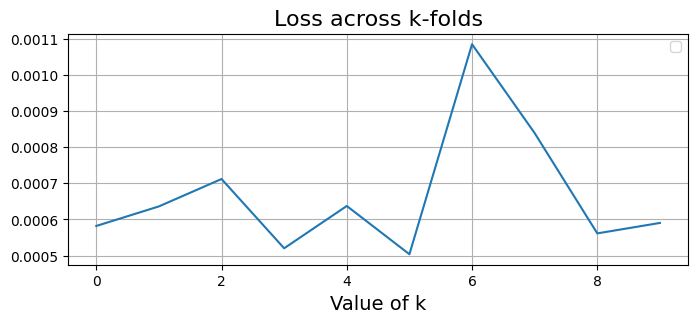

In [ ]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

### Loss curves

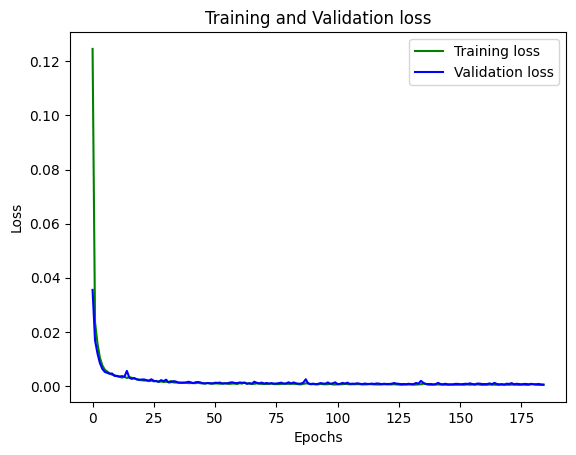

In [ ]:
# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

In [ ]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

Elapsed time: 0.0269 seconds
Maxval here is:  25.217321
Maxval here is:  0.9278


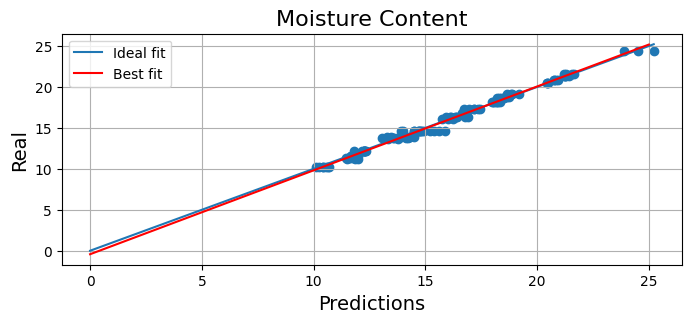

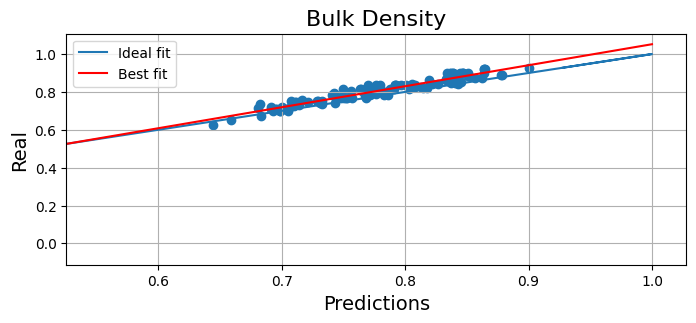

In [ ]:
import time

start_time = time.time()
Y_pred_normalized = best_model.predict(X_test_norm)
end_time = time.time()
Y_pred_normalized_entire = best_model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = np.array(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Bulk Density
scatter_plot(trueValues=Y_actual[:,1], 
             predictions=Y_pred[:,1], 
             title="Bulk Density")
plt.xlim([min(min(Y_pred[:,1]), min(Y_actual[:,1]))-0.1, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1])
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_BD.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [ ]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
# mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("{:#.4g}".format(mc_r2_score))

# BULK DENSITY
#   - R-squared
# bd_r2_score = r2_score(Y_actual[:, 1], Y_pred[:, 1])
bd_r2_score = calculate_r_squared(y_true=Y_actual[:, 1], y_pred=Y_pred[:, 1])
print("{:#.4g}".format(bd_r2_score))


0.9919
0.9215


### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sigfig import round

#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_MC: ', "{0:.4g}".format(rmse_mc))

#BD
rmse_bd = np.sqrt(mean_squared_error(Y_actual[:, 1], Y_pred[:, 1]))
print('RMSE_BD: ', "{0:.4g}".format(rmse_bd))

RMSE_MC:  0.3401
RMSE_BD:  0.03374


Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))




R^2: 0.9912
Mean Squared Error:  0.1157
Mean Absolute Error:  0.2514
Min Absolute Error:  0.0011185455322255677
Max Absolute Error:  1.2350922775268547


In [ ]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9947
Mean Squared Error:  0.07685
Mean Absolute Error:  0.2091
Min Absolute Error:  0.0008379364013677559
Max Absolute Error:  1.2350922775268547
